In [1]:
##Lib importing
##import torch
import numpy as np
import time
import random
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, models, datasets
from torchvision.utils import make_grid
from torch.optim import lr_scheduler
from PIL import Image, ImageOps
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix,f1_score, accuracy_score,precision_score, recall_score , multilabel_confusion_matrix,classification_report
import matplotlib.pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
## using new data set

new_path_train='/content/drive/MyDrive/DataSets/Aug_Data/train'
new_path_test='/content/drive/MyDrive/DataSets/Aug_Data/test'

In [ ]:
## Data loader
transform=transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor()
    ])
df_X=datasets.ImageFolder(root=new_path_train, transform=transform)
validation_per=int(len(df_X) * 0.35)
train_per=len(df_X)-validation_per
train_data, val_data =random_split(df_X, [train_per, validation_per])
train_loader=DataLoader(train_data, batch_size=16, shuffle=True)
val_loader=DataLoader(val_data, batch_size=16, shuffle=False)

In [ ]:
from torchsummary import summary
torch.manual_seed(42)
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=models.mobilenet_v2(pretrained=False).to(device)
model.classifier[1] = nn.Linear(in_features=1280, out_features=3)
summary(model, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [ ]:
#loss function
criterion=nn.CrossEntropyLoss()

In [ ]:
## lr
from torch.optim.lr_scheduler import StepLR
optimizer=torch.optim.Adam(model.parameters(), lr=0.001)
scheduler=torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.5)

In [ ]:
##calculating f1,recall,..

def Show_Result_parameters(y_dataset, y_prediction):

    acc=accuracy_score(y_dataset,y_prediction)
    print(f'Accuracy Score:{acc:.4f}')
    f1=f1_score(y_dataset,y_prediction, average='macro', zero_division=0)
    print(f'F1 Score:{f1:.4f}')
    precision=precision_score(y_dataset, y_prediction, average='macro', zero_division=0)
    print(f'Precision Score:{precision:.4f}')
    recall=recall_score(y_dataset,y_prediction, average='macro', zero_division=0)
    print(f'Recall Score:{recall:.4f}')

In [ ]:

ENumbers=25
train_losses=[]
val_losses=[]
train_accuracies=[]
val_accuracies=[]

for epoch in range(ENumbers):
    start_time=time.time()
    model.train()
    running_train_loss=0.0
    trn_correct=0
    trn_total=0

    for tr_images, tclasss in train_loader:
        tr_images, tclasss = tr_images.to(device), tclasss.to(device)

        outputs=model(tr_images)
        loss=criterion(outputs, tclasss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

        # Accuracy: use argmax to get predicted class
        predicts=torch.argmax(outputs, dim=1)
        trn_correct+=(predicts == tclasss).sum().item()
        trn_total+=tclasss.size(0)

    avg_train_loss=running_train_loss/len(train_loader)
    train_accuracy=trn_correct/trn_total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    #val data set
    model.eval()
    running_val_loss=0.0
    val_correct=0
    val_total=0
    y_predict=[]
    y_val=[]

    with torch.no_grad():
        for Val_images, classs in val_loader:
            Val_images, classs = Val_images.to(device), classs.to(device)
            outputs = model(Val_images)
            loss = criterion(outputs, classs)
            running_val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            val_correct+=(preds == classs).sum().item()
            val_total+=classs.size(0)

            y_predict.extend(preds.cpu().numpy())
            y_val.extend(classs.cpu().numpy())

    avg_val_loss = running_val_loss / len(val_loader)
    val_accuracy = val_correct / val_total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    if epoch==0:
        best_val_acc=val_accuracy
        least_val_loss = avg_val_loss
    elif val_accuracy>best_val_acc and avg_val_loss<least_val_loss:
        best_val_acc=val_accuracy
        least_val_loss=avg_val_loss
        print(f'best model until now is Epoch =[{epoch+1} in {ENumbers}]')
        torch.save(model.state_dict(),'best_MN_Xray_CNN_HW2.pt')
        torch.save(model.state_dict(), "/content/drive/MyDrive/Hw2/MN/best_MN_Xray_CNN_HW2.pth")
    scheduler.step()

    torch.save(model.state_dict(), "/content/drive/MyDrive/Hw2/MN/MN_Xray_CNN_HW2.pth")
    np.save('/content/drive/MyDrive/Hw2/MN/y_predict.npy', y_predict)
    np.save('/content/drive/MyDrive/Hw2/MN/y_val.npy', y_val)

    current_time=time.time()
    total_time=current_time-start_time
    print(f'Epoch =[{epoch+1} in {ENumbers}] Training takes {total_time/60} minutes')
    print(f'learning rate {scheduler.get_last_lr()[0]:.6f}')
    print(f'Training Loss: {avg_train_loss:.4f} & Training Acc: {train_accuracy:.4f} ** Validation Loss: {avg_val_loss:.4f} & Validation Acc: {val_accuracy:.4f}')
    print('parameters:')
    Show_Result_parameters(y_val,y_predict)
    print('------------------------------------------------------------')

Epoch =[1 in 25] Training takes 31.570834573109945 minutes
learning rate 0.001000
Training Loss: 0.5635 & Training Acc: 0.7846 ** Validation Loss: 0.8312 & Validation Acc: 0.7561
parameters:
Accuracy Score:0.7561
F1 Score:0.7447
Precision Score:0.8139
Recall Score:0.7520
------------------------------------------------------------
best model until now is Epoch =[2 in 25]
Epoch =[2 in 25] Training takes 10.623492006460825 minutes
learning rate 0.001000
Training Loss: 0.3483 & Training Acc: 0.8724 ** Validation Loss: 0.2854 & Validation Acc: 0.8975
parameters:
Accuracy Score:0.8975
F1 Score:0.8980
Precision Score:0.9052
Recall Score:0.8989
------------------------------------------------------------
Epoch =[3 in 25] Training takes 10.464464195569356 minutes
learning rate 0.001000
Training Loss: 0.2782 & Training Acc: 0.8994 ** Validation Loss: 0.5432 & Validation Acc: 0.7509
parameters:
Accuracy Score:0.7509
F1 Score:0.7232
Precision Score:0.8524
Recall Score:0.7479
---------------------

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/DataSets/Aug_Data/train/COVID19/COVID19(229).jpg'

In [ ]:
##saving the plotting variables
np.save("y_predict.npy", y_predict)
np.save("y_val.npy", y_val)
np.save('/content/drive/MyDrive/Hw2/MN/y_predict.npy', y_predict)
np.save('/content/drive/MyDrive/Hw2/MN/y_val.npy', y_val)
torch.save(model.state_dict(),'MN_Xray_CNN_HW2.pt')
torch.save(model.state_dict(), "/content/drive/MyDrive/Hw2/MN/MN_Xray_CNN_HW2.pth")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Hw2/MN/y_predict.npy'

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}


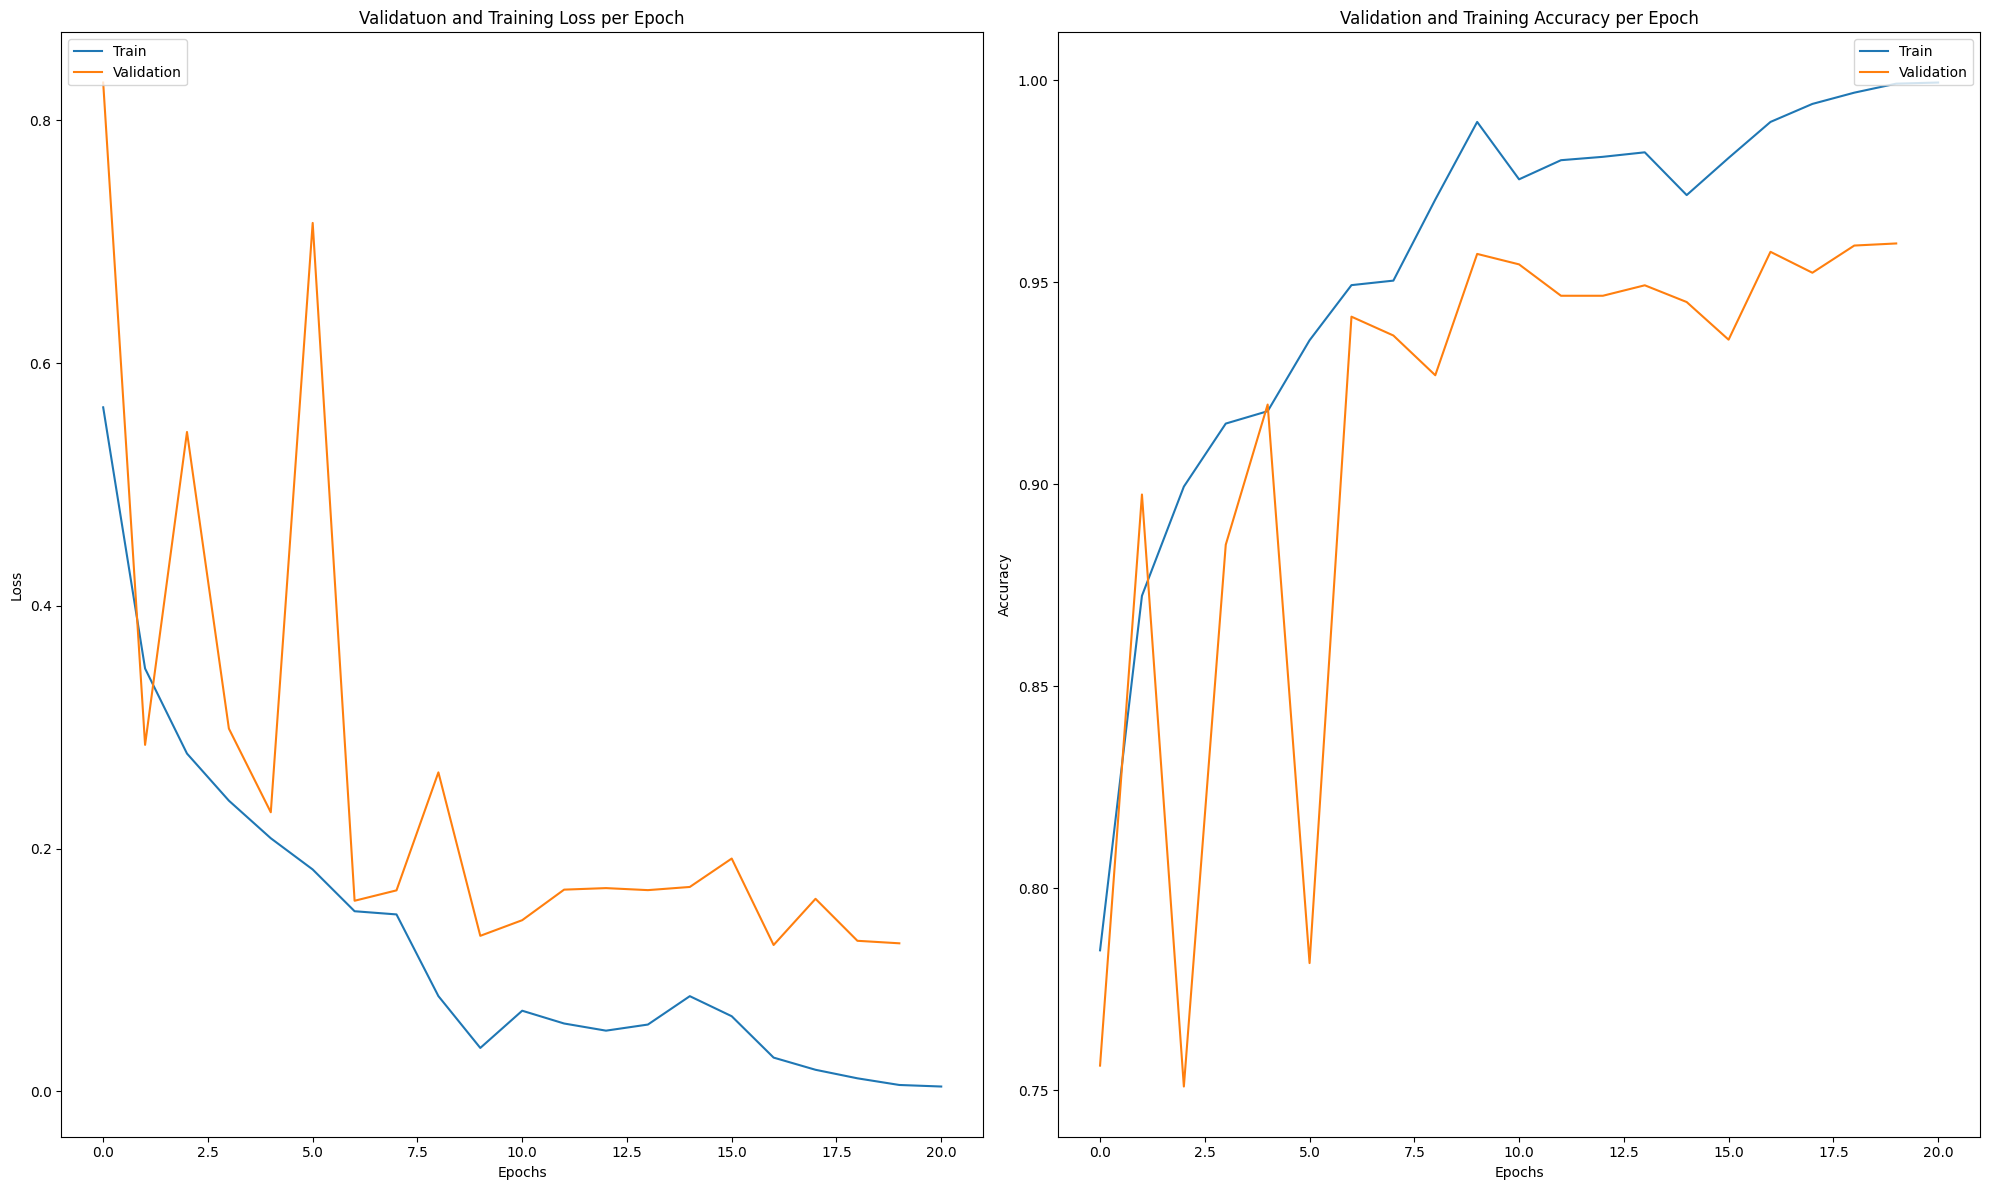

              precision    recall  f1-score   support

     COVID19       1.00      1.00      1.00        57
      NORMAL       0.94      0.94      0.94        52
   PNEUMONIA       0.96      0.96      0.96        67

    accuracy                           0.97       176
   macro avg       0.97      0.97      0.97       176
weighted avg       0.97      0.97      0.97       176



In [ ]:
labels=df_X.classes
print(df_X.class_to_idx)
plt.figure(figsize=(20,12))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validatuon and Training Loss per Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation and Training Accuracy per Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

print((classification_report(y_val,y_predict, target_names=labels)))

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}


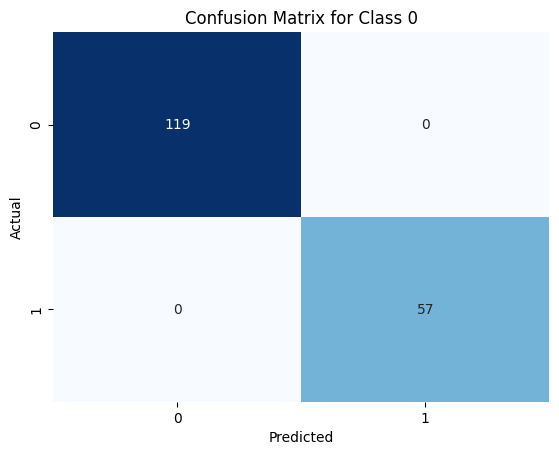

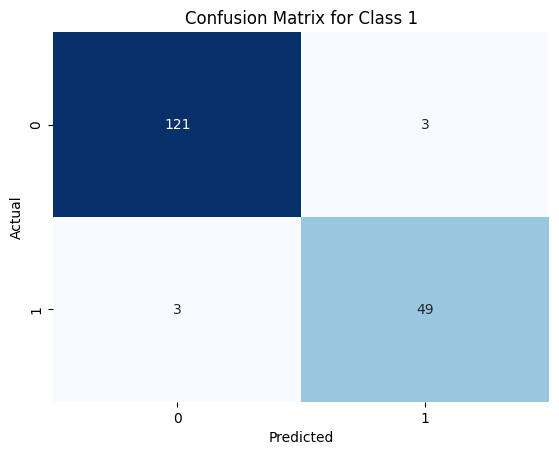

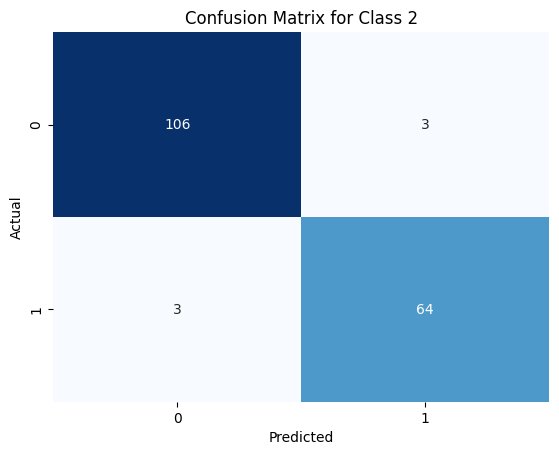

In [ ]:
ml_cm_1= multilabel_confusion_matrix(y_val,y_predict)
print(df_X.class_to_idx)
for i, cm in enumerate(ml_cm_1):
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for Class {i}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [5]:
##testing
testing_model=models.mobilenet_v2(pretrained=False)
testing_model.classifier[1] = nn.Linear(in_features=1280, out_features=3)
testing_model.load_state_dict(torch.load('/content/drive/MyDrive/Hw2/MN/MN_Xray_CNN_HW2.pth'))
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
testing_model.to(device)
testing_model.eval()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [6]:
## Data loader
transform=transforms.ToTensor()
dfT_X=datasets.ImageFolder(root=new_path_test, transform=transform)
test_loader=DataLoader(dfT_X, batch_size=16, shuffle=False)
Test_labelclass=dfT_X.classes

In [7]:
#using model
test_predict=[]
test_y=[]

with torch.no_grad():
    for test_X, test_class in test_loader:
        test_X=test_X.to(device)
        test_class = test_class.to(device)

        outputs=testing_model(test_X)
        preds=torch.argmax(outputs, dim=1)

        test_predict.extend(preds.cpu().numpy())
        test_y.extend(test_class.cpu().numpy())



In [8]:
np.save('/content/drive/MyDrive/Hw2/MN/y_test.npy', np.array(test_y))
np.save('/content/drive/MyDrive/Hw2/MN/y_test_preds.npy', np.array(test_predict))

In [9]:
print(classification_report(test_y, test_predict, target_names=Test_labelclass))


              precision    recall  f1-score   support

     COVID19       0.63      0.99      0.77       464
      NORMAL       0.96      0.58      0.73       464
   PNEUMONIA       0.88      0.72      0.79       464

    accuracy                           0.77      1392
   macro avg       0.82      0.77      0.76      1392
weighted avg       0.82      0.77      0.76      1392



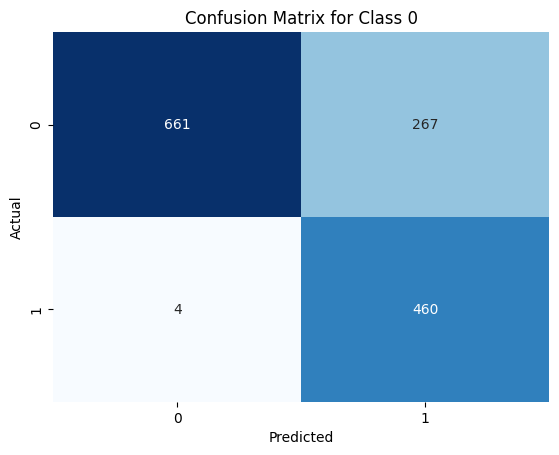

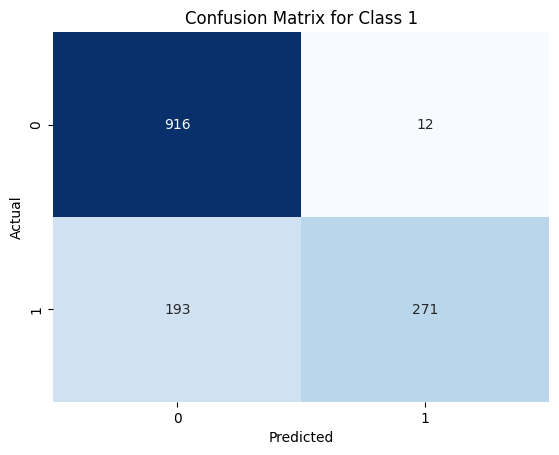

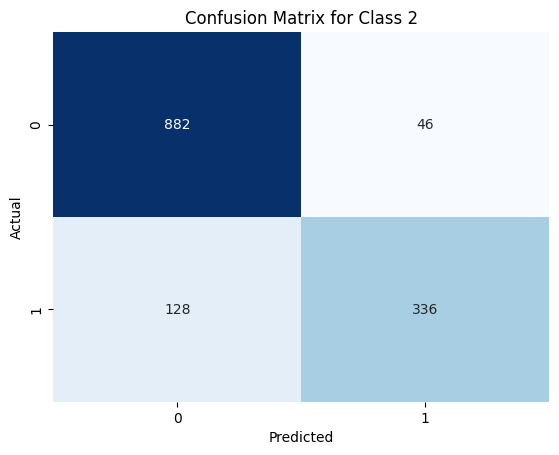

In [10]:
ml_cm_2= multilabel_confusion_matrix(test_y,test_predict)

for i, cm in enumerate(ml_cm_2):
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for Class {i}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()